# Assignment 1

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import sys

In [2]:
def show_image(imgs):
    for img in imgs:
        rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.imshow(rgb)
        plt.show()

## Part I: Applying Image Processing Filters For Image Cartoonifying

In this part of the assignment we want to make the real-world images look like they are genuinely from a cartoon. The basic idea is to fill the flat parts with some color and then draw thick lines on the strong edges. In other words, the flat areas should become much more flat and the edges should become much more distinct. We will detect edges and smooth the flat areas, then draw enhanced edges back on top to produce a cartoon or comic book effect.

In [3]:
median_const = 7
laplacian_const = 5
threshold_const = [127,255]
bilateral_const = [9,120,120]

### 1.1 Generating a black-and-white sketch

To obtain a sketch (black-and-white drawing) of the image, we will use an edge-detection filter, whereas to obtain a color painting, we will use an edge-preserving filter (bilateral filter) to further smooth the flat regions while keeping the edges intact. By overlaying the sketch drawing on top of the color painting, we obtain a cartoon effect as shown earlier in the screenshot of the final program.
There are many different edge detection filters, such as Sobel, Scharr, Laplacian filters, or Canny-edge detector. We will use a Laplacian edge filter since it produces edges that look most similar to hand sketches compared to Sobel or Scharr.


#### 1.1.1 Noise Reduction Using Median Filter

We need to reduce the noise in the image before we use a Laplacian edge filter. We will use a Median filter because it is good at removing noise while keeping edges sharp. Since Laplacian filters use grayscale images, we must convert from OpenCV’s default BGR format to Grayscale. Then for noise reduction, we apply a Median filter.

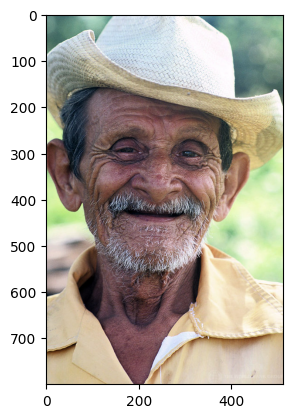

In [4]:
img = cv.imread("1.JPG")
show_image([img])

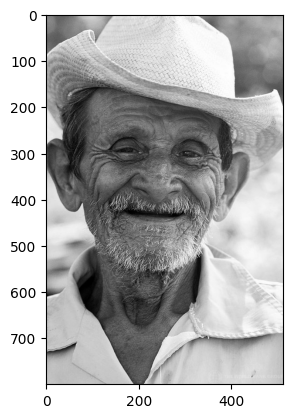

In [5]:
grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
show_image([grey])

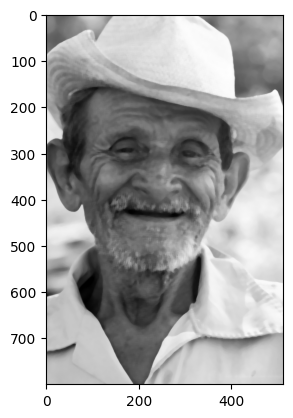

In [6]:
grey_filtered = cv.medianBlur(grey, median_const)
show_image([grey_filtered])

#### 1.1.2 Edge Detection Using Laplacian Filter

After noise reduction, a Laplacian filter is used for edge detection. The Laplacian filter produces edges with varying brightness, so to make the edges look more like a sketch we apply a binary threshold to make the edges either white or black.

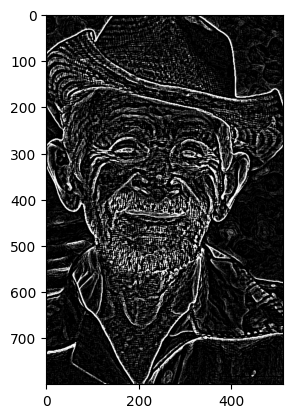

In [7]:
grey_laplacian = cv.Laplacian(grey_filtered, cv.CV_8U, ksize=laplacian_const)
show_image([grey_laplacian])

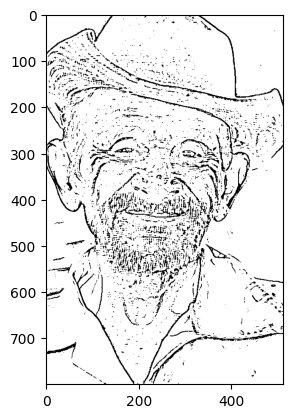

In [8]:
_,img_edges = cv.threshold(grey_laplacian,threshold_const[0],threshold_const[1],cv.THRESH_BINARY_INV)
show_image([img_edges])

### 1.2 Generating a color painting and a cartoon

A strong bilateral filter smoothes flat regions while keeping edges sharp, and is therefore great as an automatic cartoonifier or painting filter, except that it is extremely slow (that is, measured in seconds or even minutes rather than milliseconds!). We will therefore use some tricks to obtain a nice cartoonifier that still runs at an acceptable speed. The most important trick we can use is to perform bilateral filtering at a lower resolution. It will have a similar effect as at full resolution.

Rather than applying a large bilateral filter, we will apply many small bilateral filters to produce a strong cartoon effect in less time. We will truncate the filter so that instead of performing a whole filter (for example, a filter size of 21 x 21), it just uses the minimum filter size needed for a convincing result (for example, with a filter size of just 9 x 9).
We have four parameters that control the bilateral filter: color strength, positional strength, size, and repetition count.

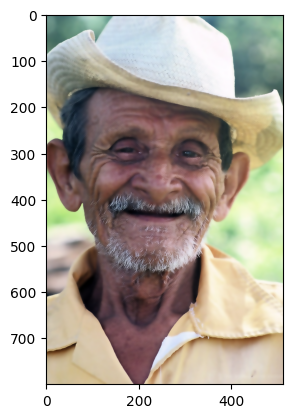

In [9]:
img_bilateral = cv.bilateralFilter(img, bilateral_const[0], bilateral_const[1], bilateral_const[2])
show_image([img_bilateral])

Then we can overlay the edge mask that we found earlier. To overlay the edge mask ”sketch” onto the bilateral filter ”painting”, we can start with a black background and copy the ”painting” pixels that aren’t edges in the ”sketch” mask.

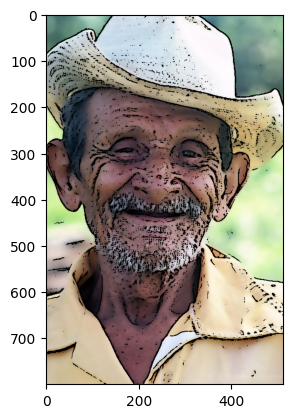

In [10]:
cartoon = cv.bitwise_and(img_bilateral, img_bilateral, mask=img_edges)
show_image([cartoon])

## Part II: Road Lane Detection Using Hough Transform

The objective of this part of the assignment is the detection of road lanes in an image using Hough Transform.

### 2.1 Hough Transform

The Hough transform can be used to determine the parameters of a line when a number of points that fall on it are known. The normal form of a line can be described with the following equation: x cos θ + y sin θ = ρ where ρ is the length of a line that starts from the origin and perpendicular to the required line, and θ is its inclination. The true parameters ρ and θ will get maximum votes from the line points, and can be found with a Hough accumulation array.

### 2.2 Implementation Details

#### 2.2.1 Smoothing the image

Smoothing the image is accomplished using a 2-dimensional median smoothing filter.

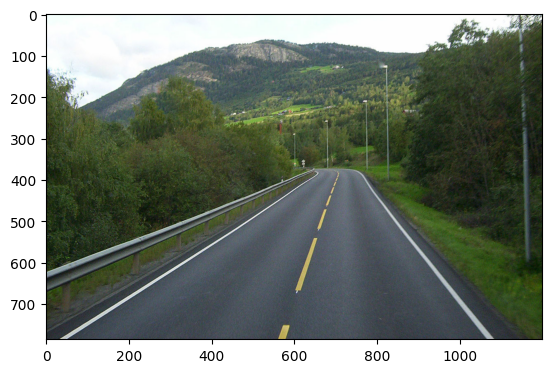

In [11]:
road = cv.imread("2.jpg")
show_image([road])

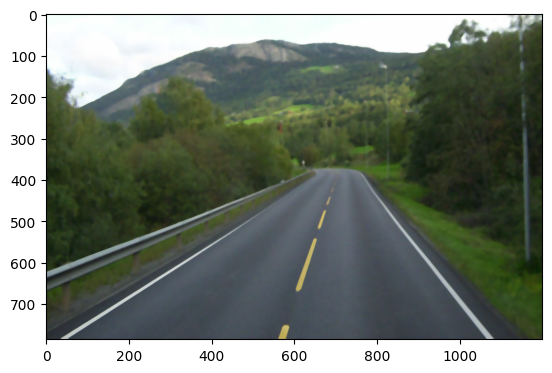

In [12]:
road_smoothed = cv.medianBlur(road, 9)
show_image([road_smoothed])

#### 2.2.2 Edge Detection

After smoothing the image, Canny’s algorithm has to be used for edge detection. We will use relatively high values for thresholding to remove most of the noise.

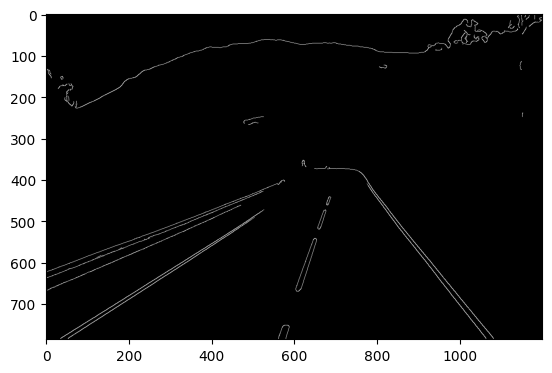

In [13]:
road_canny = cv.Canny(road_smoothed, 127, 255)
show_image([road_canny]) 

### 2.3 Region Of Interest

The output of the edge detection will contain unnecessary edges that belongs to objects outside the road. Therefore, to eliminate this noise, define a polygon (region) of the image to mask the noise edges producing only an edge image, as shown in the figure, that contains the region of interest that focus on the road.

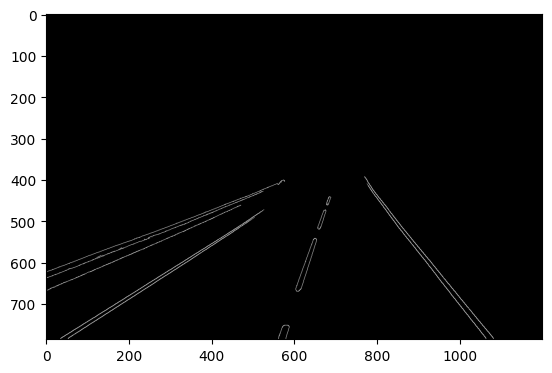

In [14]:
height, width = road_canny.shape
mask_height = height//2
rect = np.array([[(0,height),(width,height),(width,mask_height),(0,mask_height)]])
mask = np.zeros_like(road_canny)
cv.fillPoly(mask, rect, 255)
masked_road = cv.bitwise_and(road_canny, mask)
show_image([masked_road])


#### 2.3.1 Accumulation into (ρ, θ)-space using Hough transform

for each edge point (x,y) in the image:
    for θ = 0 to 180:
        ρ = x cosθ + y sinθ
        H(θ, ρ) = H(θ, ρ) + 1
    end
end 

Plot the accumulator array as an image to show the voting operation result.

In [15]:
h, w = masked_road.shape
d = int(np.ceil(np.sqrt(h**2 + w**2)))

thetas = np.deg2rad(np.arange(-90, 90+1, 1))

H = np.zeros((2*d, 180 + 1))

In [16]:
def calculate_p(x, y, theta):
    return int(x * np.cos(theta) + y * np.sin(theta))

y_s, x_s = np.nonzero(masked_road)
for i in range(len(x_s)):
    x = x_s[i]
    y = y_s[i]
    for theta in range(len(thetas)):
        p = calculate_p(x, y, thetas[theta]) + d
        H[p, theta] += 1

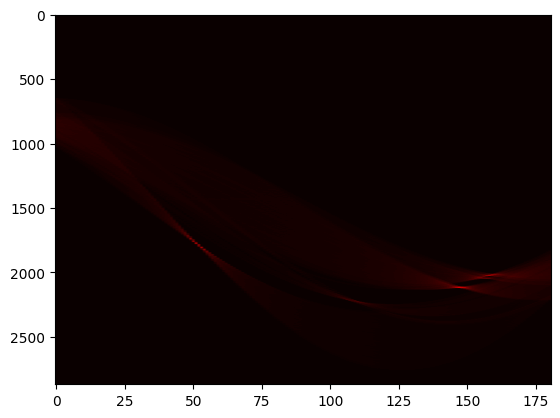

In [17]:
H = np.array(H)
plt.imshow(H, aspect='auto', cmap='hot')
plt.show()

#### 2.3.2 Refining Coordinates and HT Post-Processing

During the whole process of finding the parameters, some inaccuracies could occur. This could be due to choosing a large bin size for HT or due to noise in the detected edges. Therefore, after finding the parameters, a search in the (ρ, θ)-space is executed. We look for the highest peaks of the accumulator function and perform non-maximum suppression for lower values.

In [18]:
num_peaks = 15
neighbors = 3

indexes = []
H1 = np.copy(H)
for i in range(num_peaks):
    idx = np.argmax(H1)
    H1_idx = np.unravel_index(idx, H1.shape)
    indexes.append(H1_idx)

    idx_y, idx_x = H1_idx
    if (idx_x - (neighbors/2)) < 0:
        min_x = 0
    else: 
        min_x = idx_x - (neighbors/2)
        
    if ((idx_x + (neighbors/2) + 1) > H.shape[1]): 
        max_x = H.shape[1]
    else: 
        max_x = idx_x + (neighbors/2) + 1

    if (idx_y - (neighbors/2)) < 0: 
        min_y = 0
    else:
        min_y = idx_y - (neighbors/2)
        
    if ((idx_y + (neighbors/2) + 1) > H.shape[0]): 
        max_y = H.shape[0]
    else: 
        max_y = idx_y + (neighbors/2) + 1
        
    min_x, min_y, max_x, max_y = int(min_x), int(min_y), int(max_x), int(max_y)
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            H1[y, x] = 0
            if (x == min_x or x == (max_x)):
                H[y, x] = 255
            if (y == min_y or y == (max_y)):
                H[y, x] = 255

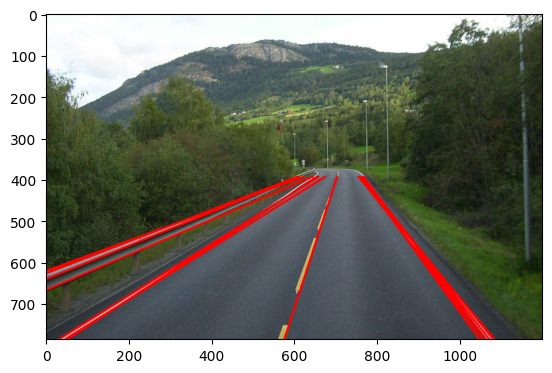

In [19]:
final_road = np.copy(road)
for i in range(len(indexes)):
    rho = indexes[i][0] - d
    theta = np.deg2rad(indexes[i][1] - 90)
    cos = np.cos(theta)
    sin = np.sin(theta)
    x0 = cos*rho
    y0 = sin*rho
    x1 = (x0 + d*(-sin))
    y1 = (y0 + d*(cos))
    x2 = (x0 - d*(-sin))
    y2 = (y0 - d*(cos))
    
    m = (y2 - y1)/(x2 - x1)
    c = y1 - m*x1
    
    def calculate_points(m, c):
        y1 = mask_height
        y2 = height
        x1 = (y1 - c)/m
        x2 = (y2 - c)/m
        return (int(x1), int(y1)), (int(x2), int(y2))
        
    point1, point2 = calculate_points(m, c)
    cv.line(final_road, point1, point2, (0,0,255), 3)

show_image([final_road])